In [1]:
import Dataset as ds
import config as cfg
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [3]:
project_name= cfg.PROJECT_NAME + '/tf_clf'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

epochs = 20

_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [4]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [5]:

augmentation_metadata = {
    'methods': {        
        'zoom': {
            'parameters': {
                'zoom_factor': 5,  # 50% of full zoom
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

#augmentation_metadata = {
#    'methods': {        
#        'flip': {
#            'parameters': {
#                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
#                'p': 1.0  # Probability of applying the augmentation
#            },
#            'apply_to_percentage': 0.5  # 50% of the training images
#        }        
#    }
#}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

An error occurred: Expected y_max for bbox (0.21131499999999998, 0.6535245, 0.770535, 1.0263375, 2) to be in the range [0.0, 1.0], got 1.0263375.


In [6]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/500 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/749 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# ClearML
https://app.clear.ml/dashboard

# Image Classifier

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from clearml import Task
import clearml
clearml.browser_login()



In [8]:
## check GPU available
#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#
## limit vram usage
#for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
# directories of train, train-aug and validation
train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
train_aug_data = tf.keras.utils.image_dataset_from_directory(train_aug_dir)
valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir)

# scale images between 0 and 1
train_data = train_data.map(lambda x,y: (x/255, y))
train_aug_data = train_aug_data.map(lambda x,y: (x/255, y))
valid_data = valid_data.map(lambda x,y: (x/255, y))

Found 500 files belonging to 3 classes.
Found 749 files belonging to 3 classes.
Found 100 files belonging to 3 classes.


In [10]:
# TEST - use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_iterator = train_data.as_numpy_iterator()
train_batch = train_iterator.next()

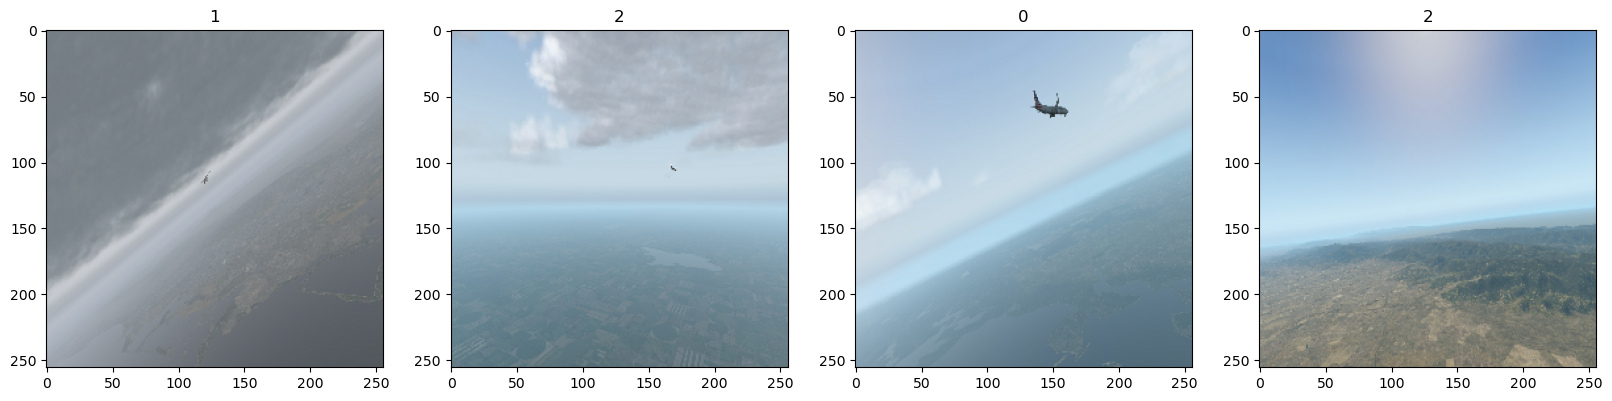

In [11]:
# TEST - visualise images with class labels
train_batch = train_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(train_batch[1][idx])


In [12]:
# use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_data.as_numpy_iterator().next()
train_aug_data.as_numpy_iterator().next()
valid_data.as_numpy_iterator().next()

print("done")


done


In [13]:
# model architecture - Also try ResNet50 or VGG16
model = Sequential()
model.add(Input(shape=(256,256,3)))  # Add an Input layer to specify the input shape
model.add(Conv2D(32, (3,3), activation='relu'))  # Notice that we no longer need to specify the input_shape here
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,702,195 (14.12 MB)

 Trainable params: 3,702,195 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# train pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

# trian model
train_hst = model.fit(train_data, epochs=hyper_params['epochs'], validation_data=valid_data, callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
# close task
task.close()

ClearML Task: created new task id=638a7debdc5644aba274a6f683eada52
2024-04-21 04:33:19,398 - clearml.Task - INFO - Storing jupyter notebook directly as code


ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/638a7debdc5644aba274a6f683eada52/output/log
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.3196 - loss: 1.4473 - val_accuracy: 0.3300 - val_loss: 1.1338
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.3217 - loss: 1.1189 - val_accuracy: 0.3400 - val_loss: 1.0978
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.2984 - loss: 1.1019 - val_accuracy: 0.3900 - val_loss: 1.0922
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.3559 - loss: 1.0939 - val_accuracy: 0.2800 - val_loss: 1.0972
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.3976 - loss: 1.1002 - val_accuracy: 0.3500 - val_loss: 1.0964
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accura

In [15]:
# train aug

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

# trian model
train_hst = model.fit(train_aug_data, epochs=hyper_params['epochs'], validation_data=valid_data, callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
# close task
task.close()

ClearML Task: created new task id=f3b91e4fd7de4bcbadb7655be7c37402
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/f3b91e4fd7de4bcbadb7655be7c37402/output/log
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.7097 - loss: 1.1154 - val_accuracy: 0.4000 - val_loss: 1.9623
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.8784 - loss: 0.3593 - val_accuracy: 0.4100 - val_loss: 2.6796
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9164 - loss: 0.2147 - val_accuracy: 0.3600 - val_loss: 3.5525
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9386 - loss: 0.1490 - val_accuracy: 0.3300 - val_loss: 3.5912
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.9560 - loss: 0.1242 - val_accuracy: 0.3300 - val_loss: 4.0302
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.9648 - loss: 0.1002 - val_accuracy: 0.3400 - val_loss: 4.9190
Epoch 7/20
24/24 ━━━━━━━